In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms

from sklearn.metrics import classification_report

In [2]:
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
folder = 'data_chinese_mnist'

In [3]:
df_labels = pd.read_csv(os.path.join(folder, 'chinese_mnist.csv'))
df_labels['file'] = df_labels.apply(lambda row: f'input_{row["suite_id"]}_{row["sample_id"]}_{row["code"]}.jpg', axis=1)
df_labels['code'] = df_labels['code'] - 1
labels_mapping = {row['code']: row['character'] for row in df_labels[['code', 'character']].groupby('code').sample(1).to_dict(orient='records')}

In [4]:
random_seed = 42

df_train = df_labels.groupby('character').sample(frac=0.8, random_state=random_seed)
df_valid = df_labels[~df_labels.index.isin(df_train.index)]
df_test = df_valid.groupby('character').sample(frac=0.5, random_state=random_seed)
df_valid = df_valid[~df_valid.index.isin(df_test.index)]

df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [5]:
class ChineseMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, df, folder, transform=None):
        self.df = df
        self.folder = folder
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(os.path.join(self.folder, row['file']))
        label = row['code']
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
train_dataset = ChineseMNISTDataset(df_train, f'{folder}/data', transform)
valid_dataset = ChineseMNISTDataset(df_valid, f'{folder}/data', transform)
test_dataset = ChineseMNISTDataset(df_test, f'{folder}/data', transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
len(train_loader), len(valid_loader), len(test_loader)

(188, 24, 24)

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):

    def step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return loss, acc

    def epoch_end(self, outputs):
        batch_losses, batch_accs = [], []
        for loss, acc in outputs:
            batch_losses.append(loss)
            batch_accs.append(acc)
        epoch_loss = torch.stack(batch_losses).mean()
        epoch_acc = torch.stack(batch_accs).mean()
        return epoch_loss, epoch_acc

def train_model(model, train_loader, valid_loader, test_loader, epochs=10, lr=0.001, weight_decay=0, grad_clip=None):
    metrics = {'epoch': [], 'train_loss': [], 'train_acc': [] , 'valid_loss': [], 'valid_acc': []}
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    lr_sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        model.train()
        train_outputs = []
        for batch in train_loader:
            loss, acc = model.step(batch)
            train_outputs.append((loss, acc))
            loss.backward()

            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()
            lr_sched.step()
            
        train_loss, train_acc = model.epoch_end(train_outputs)

        model.eval()
        with torch.no_grad():
            valid_outputs = [model.step(batch) for batch in valid_loader]
            valid_loss, valid_acc = model.epoch_end(valid_outputs)

        metrics['epoch'].append(epoch+1)
        metrics['train_loss'].append(train_loss.item())
        metrics['train_acc'].append(train_acc.item())
        metrics['valid_loss'].append(valid_loss.item())
        metrics['valid_acc'].append(valid_acc.item())
        
        print(f'Epoch [{epoch+1}/{epochs}], train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, valid_loss: {valid_loss:.4f}, valid_acc: {valid_acc:.4f}')

    model.eval()
    with torch.no_grad():
        test_outputs = [model.step(batch) for batch in test_loader]
        _, test_acc = model.epoch_end(test_outputs)

    return metrics, test_acc

In [9]:
class ChineseNN(ImageClassificationBase):

    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),

            nn.Flatten(),
            nn.Linear(32*16*16, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(512),

            nn.Linear(512, 15),
            nn.Softmax(1)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [10]:
model = ChineseNN().to(device)
metrics, test_acc = train_model(model, train_loader, valid_loader, test_loader, epochs=80, lr=0.001, weight_decay=0.0001, grad_clip=0.1)

Epoch [1/80], train_loss: 2.4991, train_acc: 0.4193, valid_loss: 2.3524, valid_acc: 0.5971
Epoch [2/80], train_loss: 2.2511, train_acc: 0.6966, valid_loss: 2.1575, valid_acc: 0.7867
Epoch [3/80], train_loss: 2.0961, train_acc: 0.8297, valid_loss: 2.0469, valid_acc: 0.8716
Epoch [4/80], train_loss: 2.0030, train_acc: 0.8984, valid_loss: 1.9767, valid_acc: 0.9154
Epoch [5/80], train_loss: 1.9417, train_acc: 0.9374, valid_loss: 1.9526, valid_acc: 0.9295
Epoch [6/80], train_loss: 1.9021, train_acc: 0.9630, valid_loss: 1.9111, valid_acc: 0.9622
Epoch [7/80], train_loss: 1.8768, train_acc: 0.9761, valid_loss: 1.8939, valid_acc: 0.9577
Epoch [8/80], train_loss: 1.8635, train_acc: 0.9790, valid_loss: 1.8975, valid_acc: 0.9557
Epoch [9/80], train_loss: 1.8556, train_acc: 0.9847, valid_loss: 1.8870, valid_acc: 0.9616
Epoch [10/80], train_loss: 1.8485, train_acc: 0.9865, valid_loss: 1.9027, valid_acc: 0.9479
Epoch [11/80], train_loss: 1.8409, train_acc: 0.9907, valid_loss: 1.8864, valid_acc: 0.94

In [11]:
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9948


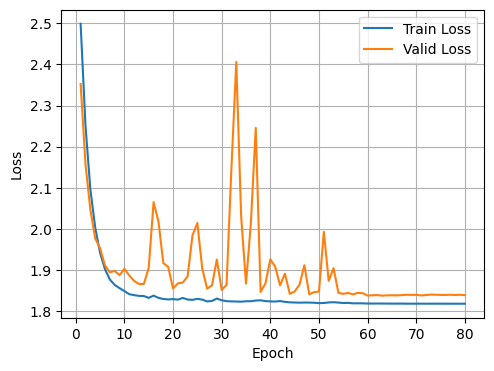

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics['epoch'], metrics['train_loss'], label='Train Loss')
plt.plot(metrics['epoch'], metrics['valid_loss'], label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

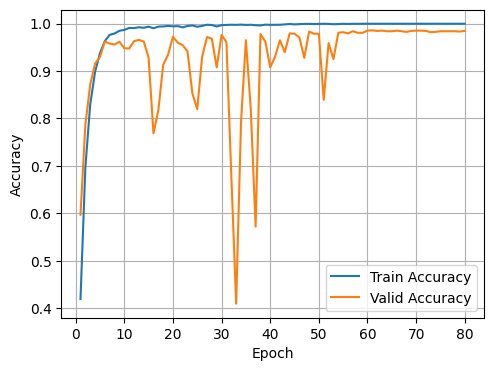

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics['epoch'], metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['epoch'], metrics['valid_acc'], label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

In [20]:
def predict_image(model, data, plot=False):
    model.eval()
    image, label = data
    with torch.no_grad():
        img = image.unsqueeze(0).to(device)
        output = model(img)
        _, pred = torch.max(output, dim=1)
        prediction = pred.item()
    
    if plot:
        print(f'Label: {labels_mapping[label]}, Prediction: {labels_mapping[prediction]}')
        plt.imshow(image[0], cmap='gray')
        plt.show()
    else:
        return label, prediction

In [15]:
torch.save(model.state_dict(), 'models/model_chinese_mnist.pth')

In [16]:
model = ChineseNN().to(device)
model.load_state_dict(torch.load('models/model_chinese_mnist.pth'))

<All keys matched successfully>

In [21]:
predictions = [predict_image(model, test_dataset[i], plot=False) for i in range(len(test_dataset))]
predictions = pd.DataFrame(predictions, columns=['label', 'prediction'])

In [22]:
print(classification_report(predictions['label'], predictions['prediction'], target_names=labels_mapping.values()))

              precision    recall  f1-score   support

           零       1.00      1.00      1.00       100
           一       0.99      1.00      1.00       100
           二       1.00      0.98      0.99       100
           三       1.00      1.00      1.00       100
           四       0.99      1.00      1.00       100
           五       0.99      1.00      1.00       100
           六       1.00      1.00      1.00       100
           七       1.00      0.99      0.99       100
           八       1.00      1.00      1.00       100
           九       0.99      1.00      1.00       100
           十       0.99      0.99      0.99       100
           百       1.00      0.98      0.99       100
           千       0.99      0.99      0.99       100
           万       0.98      1.00      0.99       100
           亿       1.00      0.99      0.99       100

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99   

Label: 百, Prediction: 百


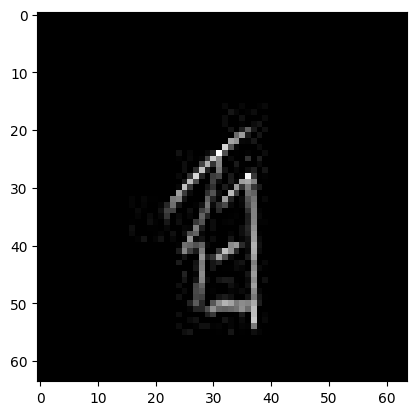

Label: 千, Prediction: 千


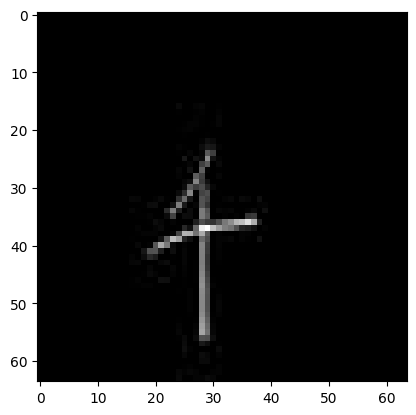

Label: 百, Prediction: 百


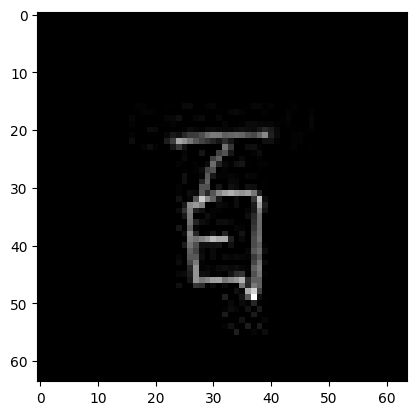

Label: 四, Prediction: 四


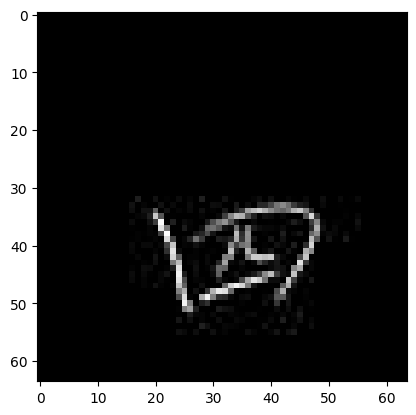

Label: 万, Prediction: 万


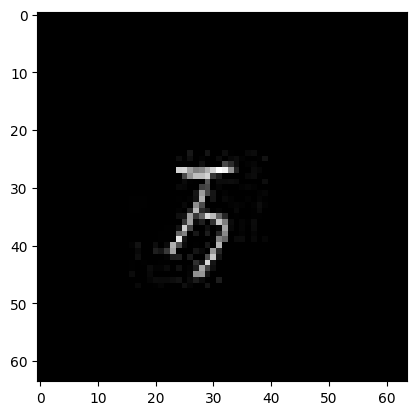

Label: 四, Prediction: 四


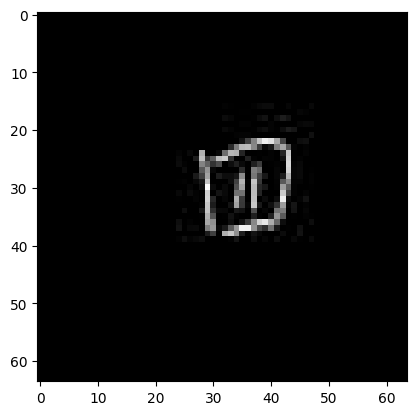

Label: 三, Prediction: 三


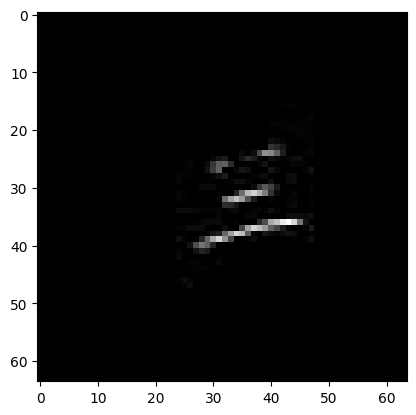

Label: 百, Prediction: 百


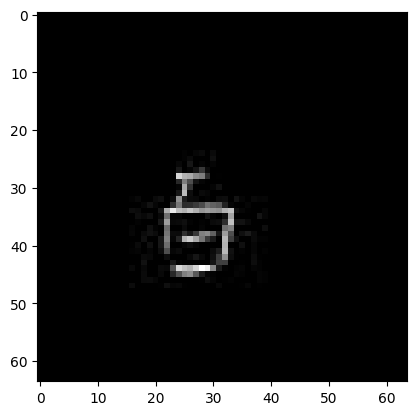

Label: 八, Prediction: 八


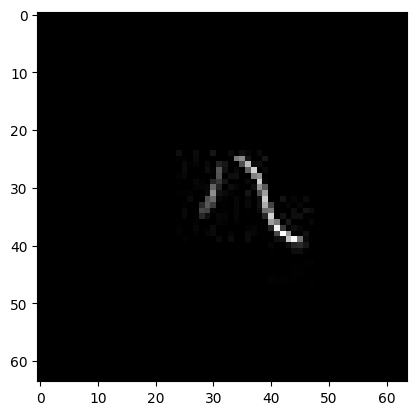

Label: 万, Prediction: 万


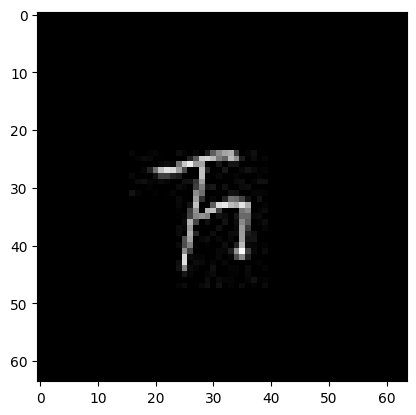

In [23]:
for idx in np.random.randint(0, len(test_dataset), 10):
    predict_image(model, test_dataset[idx], plot=True)